In [1]:
import copy 
from monai.config import print_config
from monai.transforms import (
    AddChannel, Compose, LoadImage, 
    ScaleIntensity, ToTensor, HistogramNormalize, ResizeWithPadOrCrop
)
from monai.data import write_nifti

import torch
import matplotlib.pyplot as plt
import matplotlib.colorbar
import numpy as np
import sys
sys.path.append('../')
# import scipy.ndimage

from utils.netdef import ShuffleUNet
from utils.infer_funcs import do_inference_3D

print_config()

MONAI version: 0.9.1
Numpy version: 1.19.2
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /Users/sitiyaakub/opt/anaconda3/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.2
pandas version: 1.1.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    h

In [2]:
# set device. use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set network parameters and check net shape
net = ShuffleUNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size = 3,
    up_kernel_size = 3,
    num_res_units=2
)

n = torch.rand(1, 1, 256, 256, 32)

print(net(n).shape)  # should be [1, 1, 256, 256, 32]

torch.Size([1, 1, 256, 256, 32])


In [ ]:
# set input and output data
input_mr_file = '/Users/sitiyaakub/Documents/Analysis/MRtoCT/ForGitHub/sub-test01_t1w.nii'
output_pct_file = '/Users/sitiyaakub/Documents/Analysis/MRtoCT/ForGitHub/sub-test01_pct.nii'

# trained model to load
saved_model = torch.load("/Users/sitiyaakub/Documents/Analysis/MRtoCT/ForGitHub/pretrained_net_final_20220825.pth", map_location=device)

spatial_size = [256,256,256]
t1trans_test = Compose(
    [
        HistogramNormalize(num_bins=256, min=0, max=255),
        ScaleIntensity(minv=-1.0, maxv=1.0),
        AddChannel(),
        ResizeWithPadOrCrop(spatial_size, mode='minimum'),
    ]
)

# load MRIs
print('Running MR to pCT for {}'.format(input_mr_file))
t1_arr, t1_meta = LoadImage()(input_mr_file)
orig_t1_arr = copy.copy(t1_arr)
t1_arr = t1trans_test(t1_arr)
t1_arr = t1_arr[0]

net.to(device)
net.load_state_dict(saved_model)
net.eval()

with torch.no_grad():
    ct_out = do_inference_3D(net, t1_arr, device)
    
ct_out = ResizeWithPadOrCrop(t1_meta['spatial_shape'], mode='minimum')(AddChannel()(ct_out))
write_nifti(ct_out[0], (output_pct_file), affine=t1_meta['affine'])


Running MR to pCT for /Users/sitiyaakub/Documents/Analysis/MRtoCT/ForGitHub/sub-test01_t1w.nii


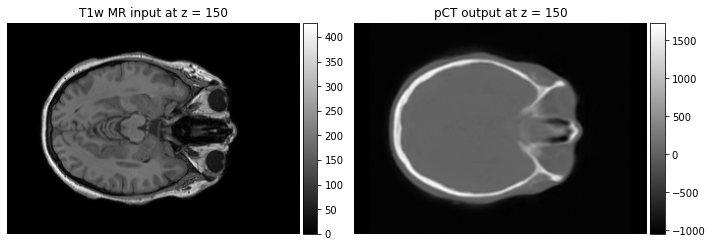

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot an example slice at z = 150
z = 150

fig = plt.figure(figsize=(10,10))

# plot input MR
ax1 = fig.add_subplot(1,2,1)
im1 = ax1.imshow(orig_t1_arr[:,:,z], cmap='gray')
ax1.set_title('T1w MR input at z = {}'.format(z))
ax1.axis('off')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

# plot output pCT
ax2 = fig.add_subplot(1,2,2)
im2 = ax2.imshow(ct_out[0,:,:,z], cmap='gray')
ax2.set_title('pCT output at z = {}'.format(z))
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.tight_layout()
